In [77]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [78]:
# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

In [79]:
# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [80]:
# Tenemos nuestro primer Agente que son los peces
class FishAgent(Agent):
    def __init__(self, unique_id, model, energy, fertility, species):
        super().__init__(unique_id, model)
        self.energy = energy
        self.fertility = 0
        self.species = species
        
    def step(self):
        steps = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(steps)
        
        if self.model.grid.is_cell_empty(new_position):
            self.model.grid.move_agent(self, new_position)
        self.energy -= 1
        if self.energy <= 0:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
        else:
            if self.fertility_threshold == 4:
                self.reproduce()
            else:
                self.fertility += 1
        
    def reproduce(self):
        if self.ferility == self.fertility_threshold:
            current_position = self.pos
            steps = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(steps)
            if self.model.grid.is_cell_empty(new_position):
                self.model.grid.move_agent(self, new_position)
                energy_of_agent = 20
                agent = FishAgent(self.model.unique_id(), self.model, energy=energy_of_agent, fertility=0)
                self.model.grid.place_agent(agent, current_position)  
                self.model.schedule.add(agent)
                self.fertility = 0
            else:
                return None
        else:
            return None
        
#Nuestro segundo agente que son los tiburones
class SharkAgent(Agent):
    def __init__(self, unique_id, model, energy, fertility, species):
        super().__init__(unique_id, model)
        self.energy = energy
        self.fertility = 0
        self.species = species
        
    def step(self):
        steps = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(steps)
        
        if self.model.grid.is_cell_empty(new_position):
            self.model.grid.move_agent(self, new_position)
        self.energy -= 1
        if self.energy <= 0:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
        else:
            self.eat()
            if self.fertility_threshold == 12:
                self.reproduce()
            else:
                self.fertility += 1
    
    def reproduce(self):
        if self.fertility == self.fertility_threshold:
            current_position = self.pos
            steps = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(steps)
            if self.model.grid.is_cell_empty(new_position):
                self.model.grid.move_agent(self, new_position)
                energy_of_agent = 3
                agent = SharkAgent(self.model.unique_id(), self.model, energy=energy_of_agent, fertility=0)
                self.model.grid.place_agent(agent, current_position)  
                self.model.schedule.add(agent)
                self.fertility = 0
                
    def eat(self):
        cellmates = []
        for n in self.model.grid.get_neighbors(self.pos, moore=False, include_center=False):
            cellmates.append(n)
        fish = [obj for obj in cellmates if isinstance(obj, FishAgent)]
        if len(fish) > 0:
            prey = self.random.choice(fish)
            (x, y) = prey.pos
            self.model.grid.remove_agent(prey)
            self.model.schedule.remove(prey)
            self.model.grid.move_agent(self, (x, y))
            self.energy += 2

In [81]:
#Esta función nos permite obtener el estado de los diferentes agentes.
# Para poder obtener la información del modelo que nos regresará una matriz con la información del estado 
# de cado uno de los agentes 
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, (x, y)) in model.grid.coord_iter():
        if (content == None):
            grid[x][y] = 0
        elif (content.species == "fish"):
            grid[x][y] = 1
        elif (content.species == "shark"):
            grid[x][y] = 2
    return grid
        

In [86]:
# Nuestro modelo que es Wa-Tor
class WatorModel(Model):
    def __init__(self, width, height, initial_fish, initial_sharks): 
        self.num_agents = initial_fish + initial_sharks
        self.unique_id = 0
        self.initial_fish = initial_fish
        self.initial_sharks = initial_sharks
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
        num_fish = initial_fish
        while self.grid.exists_empty_cells() and num_fish > 0 and self.unique_id < self.num_agents:
            empty_cells = [(x, y) for x in range(self.grid.width) for y in range(self.grid.height) if self.grid.is_cell_empty((x, y))]
            if empty_cells:
                x, y = self.random.choice(empty_cells)
                energy_of_fish, fertility_of_fish = 20, 0
                fish = FishAgent(self.unique_id, self, energy=energy_of_fish, fertility=fertility_of_fish, species="fish")
                self.grid.place_agent(fish, (x, y))
                self.schedule.add(fish)
                num_fish -= 1
                self.unique_id += 1
                
        num_sharks = initial_sharks
        while self.grid.exists_empty_cells() and num_sharks > 0 and self.unique_id < self.num_agents:
            empty_cells = [(x, y) for x in range(self.grid.width) for y in range(self.grid.height) if self.grid.is_cell_empty((x, y))]
            if empty_cells:
                x, y = self.random.choice(empty_cells)
                energy_of_shark, fertility_of_shark = 3, 0
                shark = SharkAgent(self.unique_id, self, energy=energy_of_shark, fertility=fertility_of_shark, species="shark")
                self.grid.place_agent(shark, (x, y))
                self.schedule.add(shark)
                num_sharks -= 1
                self.unique_id += 1
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    

In [90]:
#Parametros para el modelo Wa-Tor
WIDTH = 75
HEIGHT = 50
INITIAL_FISH = 120
INITIAL_SHARKS = 40

# Número de generaciones a correr
MAX_GENERATIONS = 100


# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = WatorModel(WIDTH, HEIGHT, INITIAL_FISH, INITIAL_SHARKS)
for i in range (MAX_GENERATIONS):
    model.step()

# Imprimir el tiempo que tomó correr el modelo 
#print('Tiempo de ejecución: ', str(datetime.timedalta(seconds=(time.time()-start_time))))

In [91]:
#Obtener la información que se almacenó 
all_grid = model.datacollector.get_model_vars_dataframe()

IndexError: single positional indexer is out-of-bounds

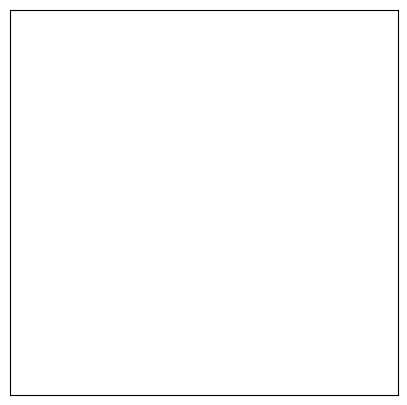

In [92]:
# Graficamos la información usando `matplotlib`
fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    data = model.datacollector.get_model_vars_dataframe().iloc[i]["Grid"]
    patch.set_data(data)
    return patch
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)
plt.show()